In [32]:
import numpy as np
import pandas as pd
from unidecode import unidecode
from difflib import SequenceMatcher

One of the most contentious and seemingly arbitrary aspects of the sport of mixed martial arts is judging decisions. If you're not familiar, every fight is either 3 or 5 rounds, and if a finish isnt achieved within the time limit, 3 judges will have judged each individual round. Each round is based off of a 10 point must system, awarding the chosen winner 10 and the loser less than 10.

Judging has been critisized by fans and fighters alike due to the vagueness of how much factors like damage, control time, grappling, octogon control, etc. are actually valued in an assessment of a round. The goal of this project is to analyze historical data across all UFC rounds, in addition to fan/media agreement on decisions. 

This notebook takes data from python code that web srapes two sites: mmadecisions.com (for decisions/ fan and media scoring) and UFCstats.com (for round by round statistics). These scripts utilizes microprocessing to optimize the time it takes to gether all the information. We start by converting the combined csv files to a 103x2306 dataframe.

In [56]:
UFC_df = pd.read_csv('output.csv')
UFC_df.head(15)
#method: 0= KO/TKO, 1= Submission, 2 =Unanimous decision, 3=Split decision, 4=NC/DRAW

,Number_of_Rounds,Opponent_A_Wins,Method,Opponent_A,Total_Strikes_Attempted_(A),Round_1_Sig_Strikes_Attempted_(A),Round_1_Sig_Strikes_Landed_(A),Round_1_KD_(A),Round_1_TD_(A),Round_1_Sub_Attempts_(A),...,Rd2C,Rd3C,Rd4C,Rd5C,Media score ratio of agreement,Rd1 Fans,Rd2 Fans,Rd3 Fans,Rd4 Fans,Rd5 Fans
0,5,1,2,Mackenzie Dern,340,42,23,1,0,0,...,-1,2,1,2,1.0,1.622,-0.828,2.043,0.926,1.741
1,3,1,2,Karolina Kowalkiewicz,249,84,42,0,0,0,...,1,1,--,--,1.0,NaN,NaN,NaN,NaN,NaN
2,3,0,3,Ilir Latifi,105,44,28,0,0,0,...,-1,-1,--,--,0.923,0.842,-0.684,0.316,NaN,NaN
3,3,1,2,Chase Hooper,340,101,60,0,0,0,...,1,1,--,--,1.0,1.267,0.999,1.001,NaN,NaN
4,3,0,2,Takashi Sato,76,8,3,0,1,0,...,1,1,--,--,1.0,NaN,NaN,NaN,NaN,NaN
5,3,0,2,Anthony Smith,95,22,10,0,1,0,...,-1,1,--,--,1.0,0.955,0.254,1.150,NaN,NaN
6,3,1,2,Karl Williams,191,43,19,0,1,0,...,-1,1,--,--,1.0,0.914,-0.392,-0.044,NaN,NaN
7,3,0,2,Cody Stamann,152,39,14,0,1,0,...,1,-1,--,--,0.714,0.531,0.698,-1.094,NaN,NaN
8,3,0,3,Ji Yeon Kim,62,5,1,0,0,0,...,-1,-1,--,--,0.091,-0.696,0.033,0.043,NaN,NaN
9,5,1,3,Aljamain Sterling,261,34,20,0,2,0,...,1,-1,1,-1,0.913,0.904,-0.330,-0.167,0.826,-0.890


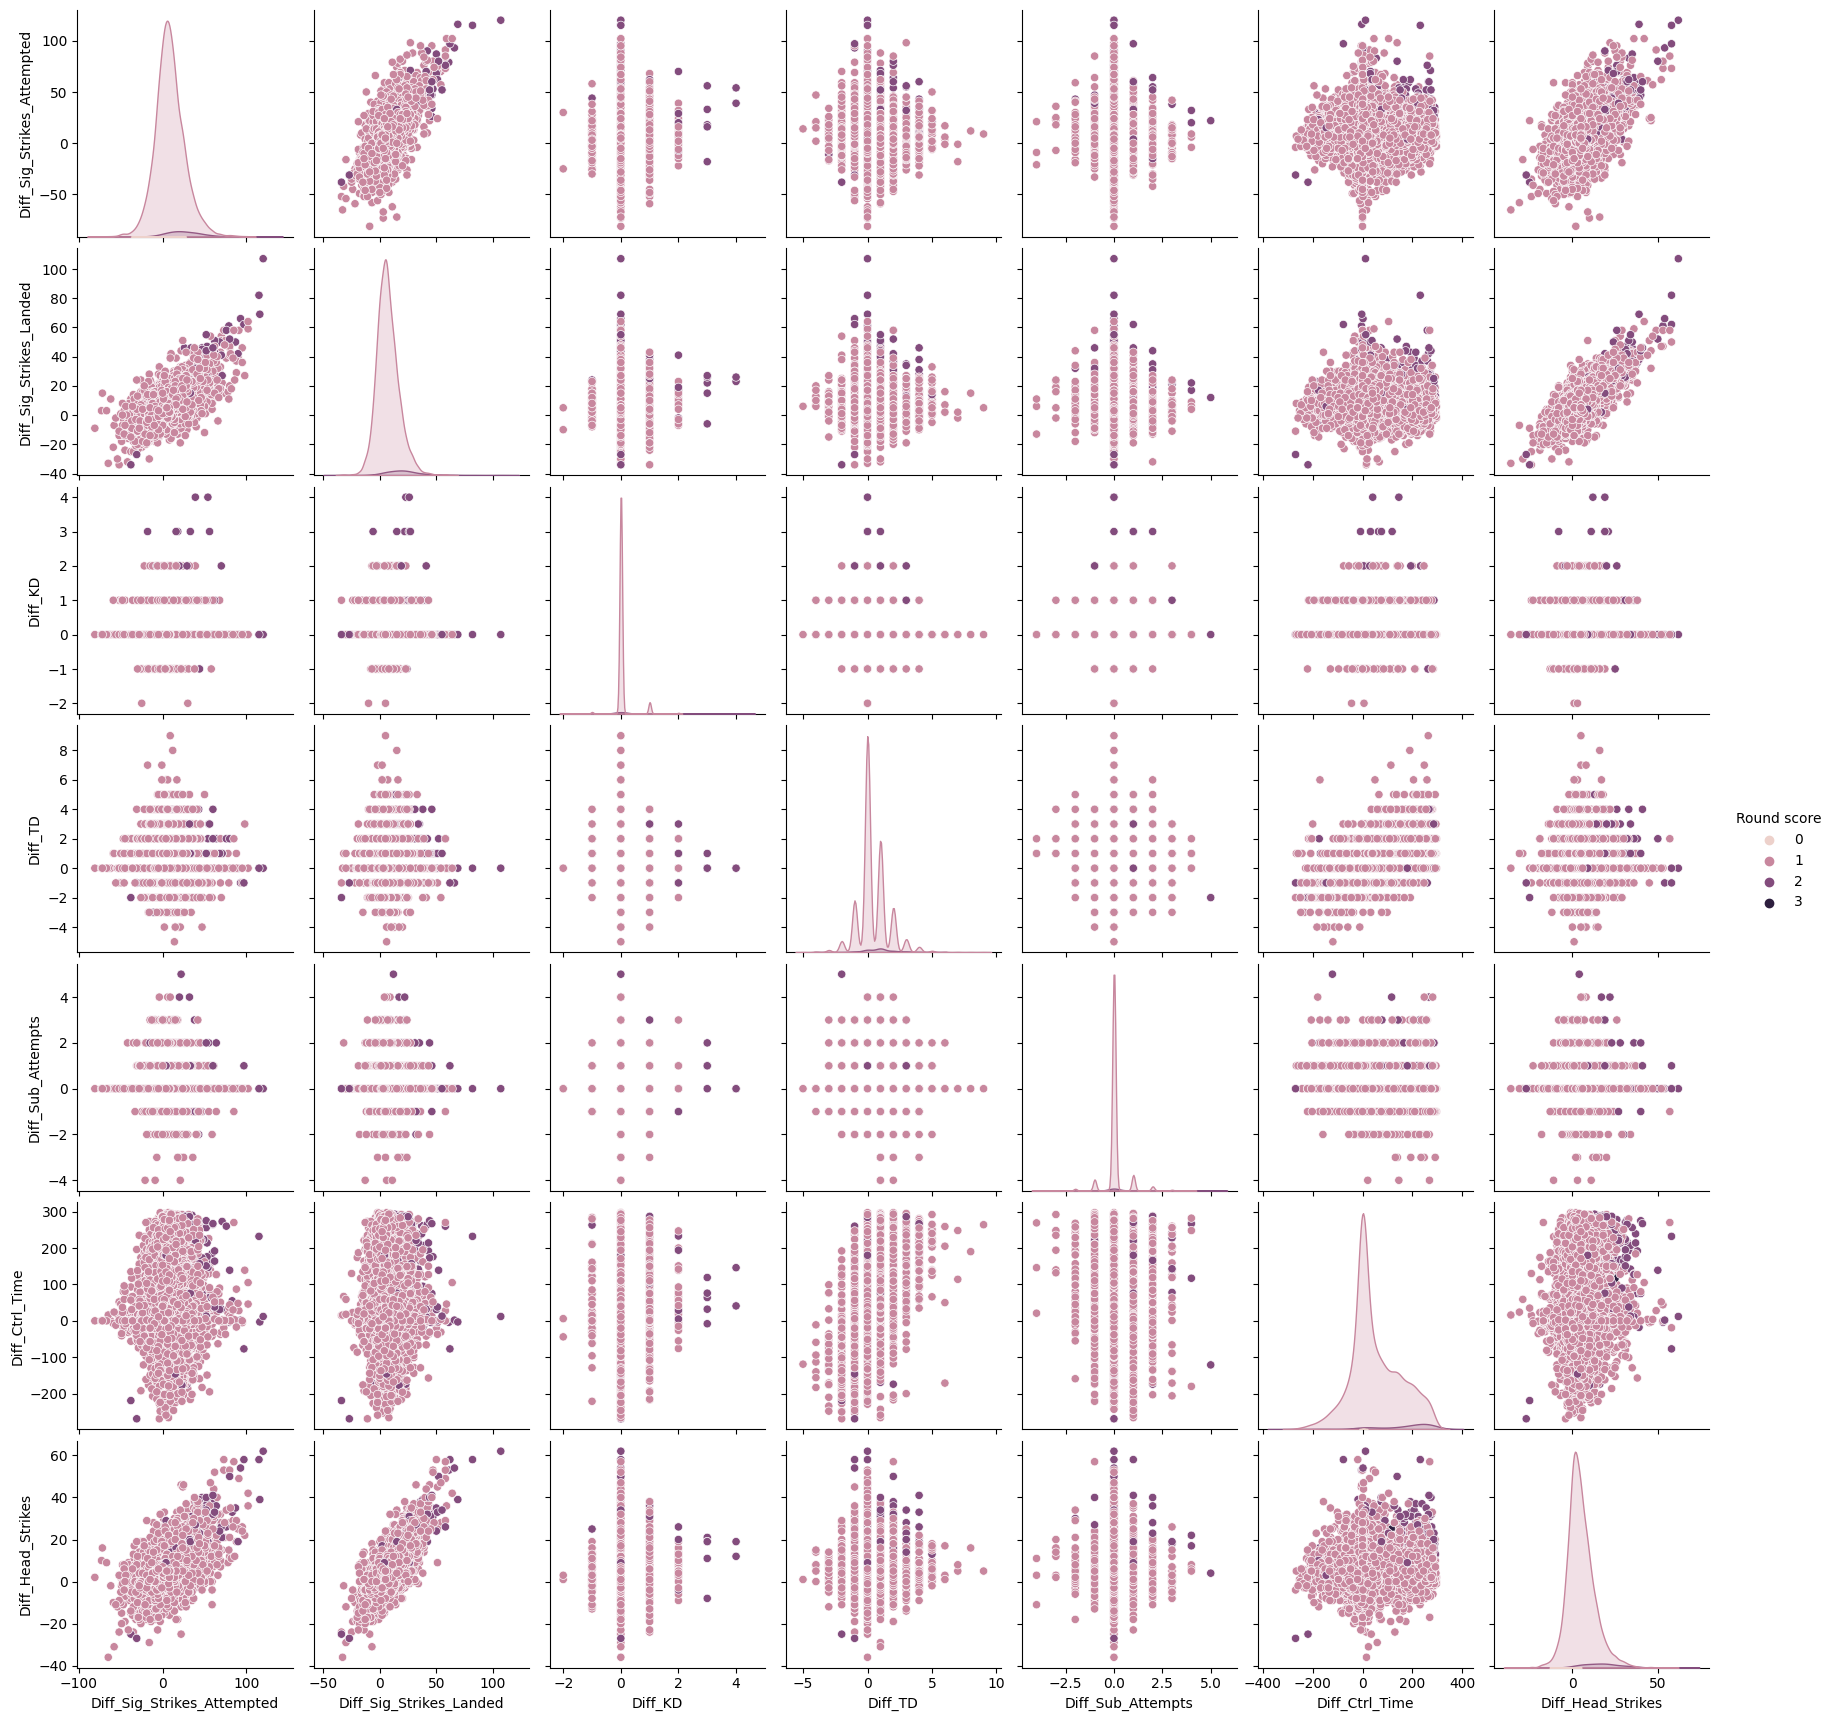

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

def get_sec(time_str):
    m, s = time_str.split(':')
    return int(m) * 60 + int(s)

new_columns =[ 'Round score', 'Diff_Sig_Strikes_Attempted','Diff_Sig_Strikes_Landed','Diff_KD','Diff_TD','Diff_Sub_Attempts','Diff_Ctrl_Time','Diff_Head_Strikes']
rounds_df = pd.DataFrame(columns=new_columns)
for rowtuple in UFC_df.itertuples():
    row= list(rowtuple)[1:]
    list1 =[int(row [82]),int(row [87]), int(row [92])]
    round1avg = max(set(list1), key=list1.count)

    list2 =[int(row [83]),int(row [88]), int(row [93])]
    round2avg = max(set(list2), key=list2.count)

    list3 =[int(row [84]),int(row [89]), int(row [94])]
    round3avg = max(set(list3), key=list3.count)

    if((row[85] != 'nan') & (row[85] != '--')):
        list4 =[int(row [85]),int(row [90]), int(row [95])]
        round4avg = max(set(list4), key=list4.count)
        list5 =[int(row [86]),int(row [91]), int(row [96])]
        round5avg = max(set(list5), key=list5.count)

    else:
        round4avg ='skip'
        round5avg ='skip'

    round1infoA = row[5:12]
    round2infoA = row[12:19]
    round3infoA = row[19:26]
    round4infoA = row[26:33]
    round5infoA = row[33:40]

    round1infoB = row[42:49]
    round2infoB = row[49:56]
    round3infoB = row[56:63]
    round4infoB = row[63:70]
    round5infoB = row[70:77]

    if(row[80]=='DRAW'):
        if(  SequenceMatcher(a=unidecode(row[81]).lower(), b=unidecode(row[3]).lower()).ratio() >=0.8):
            templist =[round1infoA,round2infoA,round3infoA,round4infoA,round5infoA,
                    round1infoB,round2infoB,round3infoB,round4infoB,round5infoB]
        else:
            templist =[round1infoB,round2infoB,round3infoB,round4infoB,round5infoB,
                    round1infoA,round2infoA,round3infoA,round4infoA,round5infoA,]
    else:
        if (int(row[1])== 1):
            templist =[round1infoA,round2infoA,round3infoA,round4infoA,round5infoA,
                    round1infoB,round2infoB,round3infoB,round4infoB,round5infoB]
        else:
            templist =[round1infoB,round2infoB,round3infoB,round4infoB,round5infoB,
                    round1infoA,round2infoA,round3infoA,round4infoA,round5infoA,]
    
    for info in templist:
        if(info[5] != '--'):
            info[5] = get_sec(info[5])


    if(round1avg >= 0):
        rinfo =templist[0]
        rinfo = [int(element1) - int(element2) for (element1, element2) in zip(rinfo, templist[5])]
        rinfo.insert(0, int(round1avg))
        rounds_df.loc[len(rounds_df.index)] = rinfo
    else:
        rinfo =templist[5]
        rinfo = [int(element1) - int(element2) for (element1, element2) in zip(rinfo, templist[0])]
        rinfo.insert(0, -int(round1avg))
        rounds_df.loc[len(rounds_df.index)] = rinfo

    if(round2avg >= 1):
        rinfo =templist[1]
        rinfo = [int(element1) - int(element2) for (element1, element2) in zip(rinfo, templist[6])]
        rinfo.insert(0, int(round2avg))
        rounds_df.loc[len(rounds_df.index)] = rinfo
    else:
        rinfo =templist[6]
        rinfo = [int(element1) - int(element2) for (element1, element2) in zip(rinfo, templist[1])]
        rinfo.insert(0,  -int(round2avg))
        rounds_df.loc[len(rounds_df.index)] = rinfo           

    if(round3avg >= 1):
        rinfo =templist[2]
        rinfo = [int(element1) - int(element2) for (element1, element2) in zip(rinfo, templist[7])]
        rinfo.insert(0, int(round3avg))
        rounds_df.loc[len(rounds_df.index)] = rinfo
    else:
        rinfo =templist[7]
        rinfo = [int(element1) - int(element2) for (element1, element2) in zip(rinfo, templist[2])]
        rinfo.insert(0,  -int(round3avg))
        rounds_df.loc[len(rounds_df.index)] = rinfo            

    if(round4avg != 'skip'):
        if(round4avg >= 1):
            rinfo =templist[3]
            rinfo = [int(element1) - int(element2) for (element1, element2) in zip(rinfo, templist[8])]
            rinfo.insert(0, int(round4avg))
            rounds_df.loc[len(rounds_df.index)] = rinfo
        else:
            rinfo =templist[8]
            rinfo = [int(element1) - int(element2) for (element1, element2) in zip(rinfo, templist[3])]
            rinfo.insert(0,  -int(round4avg))
            rounds_df.loc[len(rounds_df.index)] = rinfo           

    if(round5avg != 'skip'):
        if(round5avg >= 1):
            rinfo =templist[4]
            rinfo = [int(element1) - int(element2) for (element1, element2) in zip(rinfo, templist[9])]
            rinfo.insert(0, int(round5avg))
            rounds_df.loc[len(rounds_df.index)] = rinfo
        else:           
            rinfo =templist[9]
            rinfo = [int(element1) - int(element2) for (element1, element2) in zip(rinfo, templist[4])]
            rinfo.insert(0,  -int(round5avg))
            rounds_df.loc[len(rounds_df.index)] = rinfo
rounds_df.head(35)
sns.pairplot(rounds_df[[ 'Diff_Sig_Strikes_Attempted','Diff_Sig_Strikes_Landed','Diff_KD','Diff_TD','Diff_Sub_Attempts','Diff_Ctrl_Time','Diff_Head_Strikes','Round score']], hue='Round score')


In [65]:
rounds_df.to_csv( 'rounds.csv', index=False)